# Persiapan Library

In [1]:
import torch, time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
if torch.cuda.is_available():
    print("Device:",torch.cuda.current_device())
    print("Device Name:",torch.cuda.get_device_name())

Device: 0
Device Name: Tesla T4


# Preprocessing

In [3]:
img_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(0.4),
    transforms.RandomVerticalFlip(0.3),
    transforms.Resize((240,240)),
    transforms.CenterCrop((240,240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])
img_transforms

Compose(
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.4)
    RandomVerticalFlip(p=0.3)
    Resize(size=(240, 240), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(240, 240))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [4]:
data_dir = "/content/drive/MyDrive/weavisproject/dataset"
dataset = datasets.ImageFolder(root=data_dir,transform=img_transforms)

In [5]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [6]:
len(dataset)

4250

In [7]:
train_set, test_set = random_split(dataset=dataset,lengths=[0.8,0.2])

In [8]:
train_loader = DataLoader(dataset=train_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device="cuda")
test_loader = DataLoader(dataset=test_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device="cuda")

In [9]:
for images, labels in train_loader:
    break

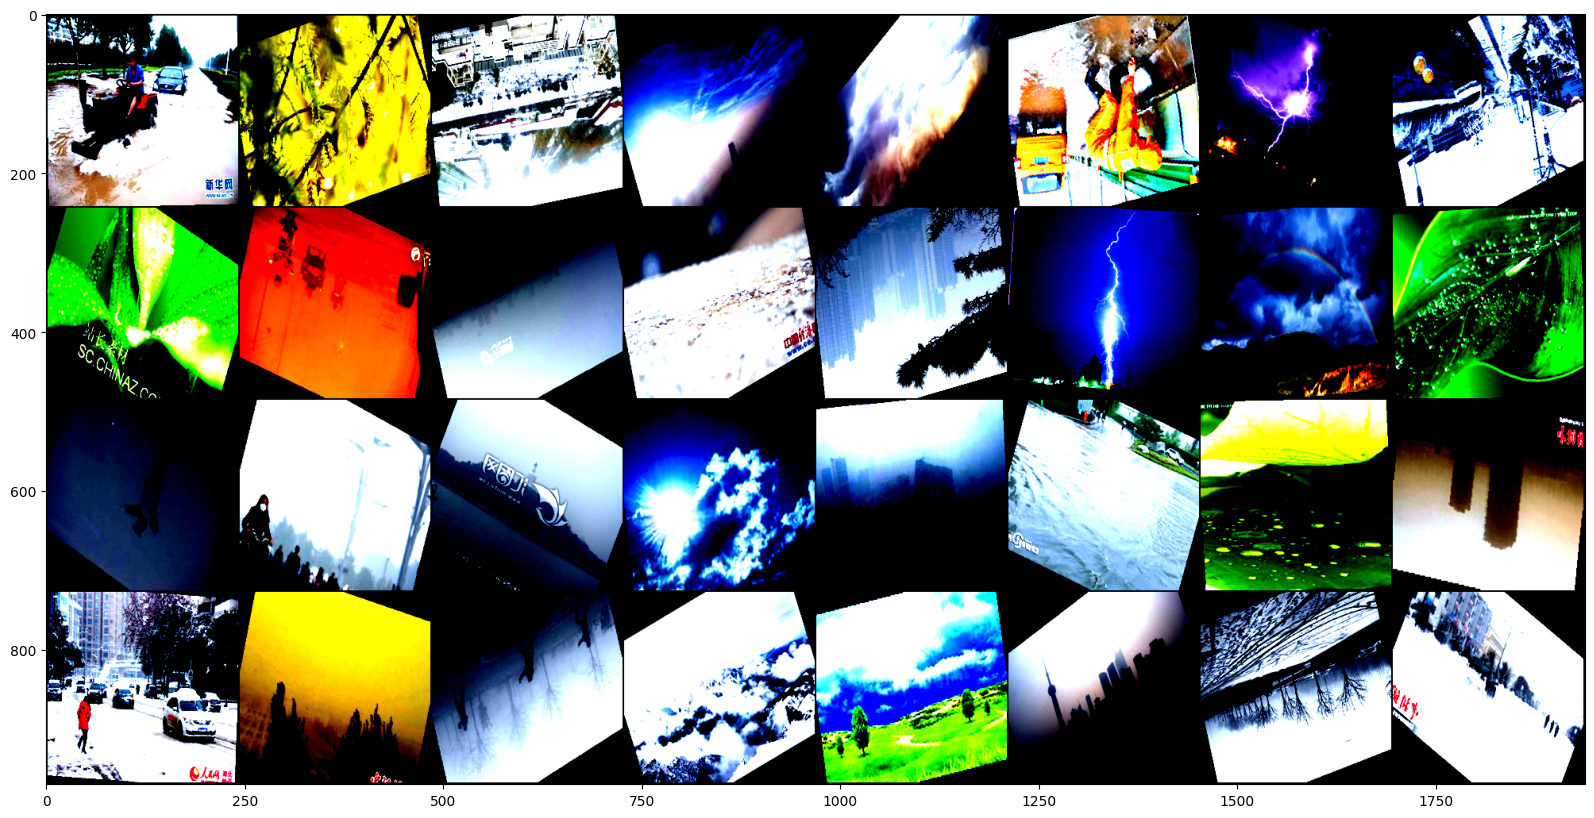

In [10]:
img_grid = make_grid(images,nrow=8)

inv_normalize = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
inv_normalized_images = inv_normalize(images)

plt.figure(figsize=(20,10))
plt.imshow(np.transpose(img_grid.numpy(),(1,2,0)));

In [11]:
images.shape

torch.Size([32, 3, 240, 240])

# Training Model

In [12]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1)
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1)
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1)
        self.conv4 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1)
        self.fc1 = nn.Linear(in_features=13*13*512,out_features=512)
        self.fc2 = nn.Linear(in_features=512,out_features=256)
        self.fc3 = nn.Linear(in_features=256,out_features=128)
        self.fc4 = nn.Linear(in_features=128,out_features=64)
        self.fc5 = nn.Linear(in_features=64,out_features=32)
        self.fc6 = nn.Linear(in_features=32,out_features=8)

    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = X.view(-1,13*13*512)
        X = F.relu(self.fc1(X))
        X = F.dropout(X,p=0.45)
        X = F.relu(self.fc2(X))
        X = F.dropout(X,p=0.35)
        X = F.relu(self.fc3(X))
        X = F.dropout(X,p=0.25)
        X = F.relu(self.fc4(X))
        X = F.dropout(X,p=0.2)
        X = F.relu(self.fc5(X))
        X = F.dropout(X,p=0.1)
        X = self.fc6(X)
        return F.log_softmax(X,dim=1)

In [14]:
torch.manual_seed(48)
model = CNN().cuda()
model

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=86528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=8, bias=True)
)

In [15]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 46028648


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),lr=0.001)

In [17]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = model(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Durasi melatih model: {(time.time()-start_time)/60} menit.")

Epoch 1 Batch 50 -> Loss: 1.8089784383773804
Epoch 1 Batch 100 -> Loss: 1.4873387813568115
Epoch 2 Batch 50 -> Loss: 1.2924995422363281
Epoch 2 Batch 100 -> Loss: 1.4463051557540894
Epoch 3 Batch 50 -> Loss: 1.037222146987915
Epoch 3 Batch 100 -> Loss: 1.1345583200454712
Epoch 4 Batch 50 -> Loss: 1.904266119003296
Epoch 4 Batch 100 -> Loss: 1.055325984954834
Epoch 5 Batch 50 -> Loss: 1.0450083017349243
Epoch 5 Batch 100 -> Loss: 0.8896386623382568
Epoch 6 Batch 50 -> Loss: 0.8958624601364136
Epoch 6 Batch 100 -> Loss: 1.9621533155441284
Epoch 7 Batch 50 -> Loss: 0.8341912031173706
Epoch 7 Batch 100 -> Loss: 1.0669546127319336
Epoch 8 Batch 50 -> Loss: 0.6302882432937622
Epoch 8 Batch 100 -> Loss: 0.9558267593383789
Epoch 9 Batch 50 -> Loss: 0.9260985255241394
Epoch 9 Batch 100 -> Loss: 0.9025450348854065
Epoch 10 Batch 50 -> Loss: 0.5026828646659851
Epoch 10 Batch 100 -> Loss: 1.163665533065796
Epoch 11 Batch 50 -> Loss: 0.8369254469871521
Epoch 11 Batch 100 -> Loss: 1.0651296377182007

# Evaluasi Model

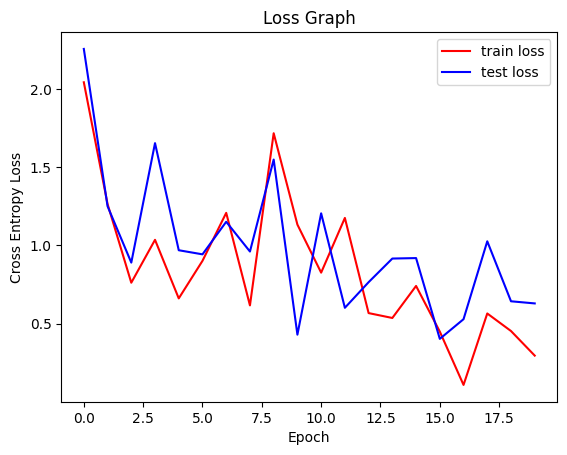

In [18]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

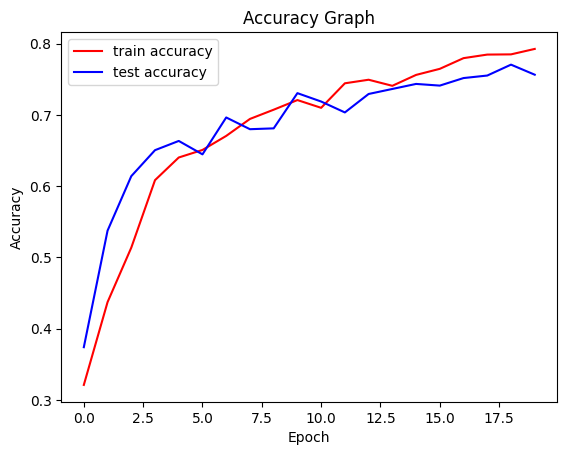

In [19]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [20]:
print(f"Akurasi Training Tertinggi: {max(train_accuracies):.2f}")
print(f"Akurasi Testing Tertinggi: {max(test_accuracies):.2f}")

Akurasi Training Tertinggi: 0.79
Akurasi Testing Tertinggi: 0.77


# Dengan Arsitektur ResNet50

In [29]:
resnet = models.resnet50(pretrained=True)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [30]:
total_params = 0

for param in resnet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total parameters of pretrained ResNet50 model:", total_params)

9408
64
64
4096
64
64
36864
64
64
16384
256
256
16384
256
256
16384
64
64
36864
64
64
16384
256
256
16384
64
64
36864
64
64
16384
256
256
32768
128
128
147456
128
128
65536
512
512
131072
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
131072
256
256
589824
256
256
262144
1024
1024
524288
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
524288
512
512
2359296
512
512
1048576
2048
2048
2097152
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
2048000
1000
Total parameters of pretrained ResNet50 model: 25557032


In [31]:
resnet.fc = nn.Sequential(
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,8),
    nn.LogSoftmax(dim=1)
)
resnet = resnet.cuda()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=resnet.parameters(),lr=0.001)

In [33]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = resnet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = resnet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Durasi melatih model: {(time.time()-start_time)/60} menit.")

Epoch 1 Batch 50 -> Loss: 0.7330494523048401
Epoch 1 Batch 100 -> Loss: 0.44687625765800476
Epoch 2 Batch 50 -> Loss: 0.46274441480636597
Epoch 2 Batch 100 -> Loss: 0.5017209053039551
Epoch 3 Batch 50 -> Loss: 0.39638498425483704
Epoch 3 Batch 100 -> Loss: 0.534700870513916
Epoch 4 Batch 50 -> Loss: 0.1552477329969406
Epoch 4 Batch 100 -> Loss: 0.48344719409942627
Epoch 5 Batch 50 -> Loss: 0.35668542981147766
Epoch 5 Batch 100 -> Loss: 0.162193164229393
Epoch 6 Batch 50 -> Loss: 0.15760567784309387
Epoch 6 Batch 100 -> Loss: 0.6132969856262207
Epoch 7 Batch 50 -> Loss: 0.292954683303833
Epoch 7 Batch 100 -> Loss: 0.4869731068611145
Epoch 8 Batch 50 -> Loss: 0.4760289192199707
Epoch 8 Batch 100 -> Loss: 0.23248891532421112
Epoch 9 Batch 50 -> Loss: 0.38659679889678955
Epoch 9 Batch 100 -> Loss: 0.293418824672699
Epoch 10 Batch 50 -> Loss: 0.4283055365085602
Epoch 10 Batch 100 -> Loss: 0.17134292423725128
Epoch 11 Batch 50 -> Loss: 0.28194311261177063
Epoch 11 Batch 100 -> Loss: 0.446769

**Evaluasi Loss**

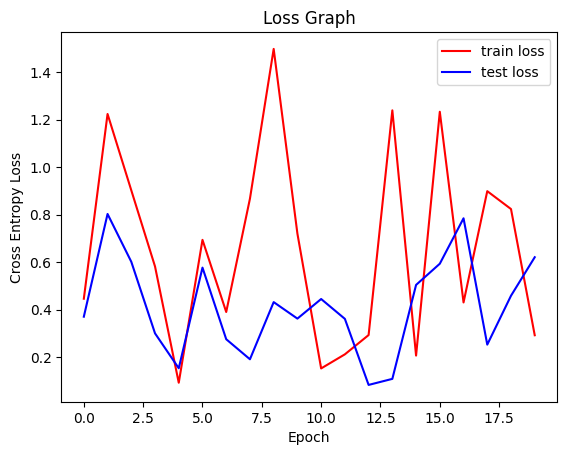

In [34]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

**Evaluasi Akurasi**

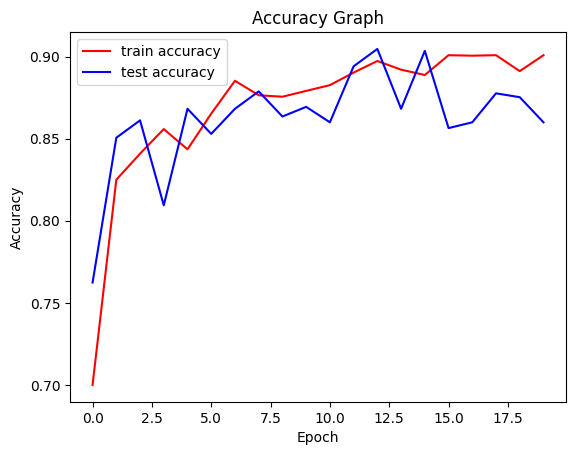

In [35]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [36]:
print(f"Akurasi Training Tertinggi: {max(train_accuracies):.2f}")
print(f"Akurasi Testing Tertinggi: {max(test_accuracies):.2f}")

Akurasi Training Tertinggi: 0.90
Akurasi Testing Tertinggi: 0.90


# Dengan Arsitektur AlexNet

In [37]:
alexnet = models.alexnet(pretrained=True)
alexnet

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 195MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [38]:
total_params = 0

for param in alexnet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total parameters of the AlexNet model:", total_params)

23232
64
307200
192
663552
384
884736
256
589824
256
37748736
4096
16777216
4096
4096000
1000
Total parameters of the AlexNet model: 61100840


In [39]:
alexnet.classifier = nn.Sequential(
    nn.Linear(9216,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,8),
    nn.LogSoftmax(dim=1)
)
alexnet = alexnet.cuda()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=2048, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=alexnet.parameters(),lr=0.001)

In [41]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = alexnet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = alexnet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Durasi melatih model: {(time.time()-start_time)/60} menit.")

Epoch 1 Batch 50 -> Loss: 0.8651721477508545
Epoch 1 Batch 100 -> Loss: 0.5949611663818359
Epoch 2 Batch 50 -> Loss: 0.5169858932495117
Epoch 2 Batch 100 -> Loss: 0.5384840965270996
Epoch 3 Batch 50 -> Loss: 0.2985226511955261
Epoch 3 Batch 100 -> Loss: 0.6342694163322449
Epoch 4 Batch 50 -> Loss: 0.19875456392765045
Epoch 4 Batch 100 -> Loss: 0.28486377000808716
Epoch 5 Batch 50 -> Loss: 0.272579163312912
Epoch 5 Batch 100 -> Loss: 0.42978978157043457
Epoch 6 Batch 50 -> Loss: 0.3875579833984375
Epoch 6 Batch 100 -> Loss: 0.17271673679351807
Epoch 7 Batch 50 -> Loss: 0.4007303714752197
Epoch 7 Batch 100 -> Loss: 0.2292601764202118
Epoch 8 Batch 50 -> Loss: 0.20448629558086395
Epoch 8 Batch 100 -> Loss: 0.25488635897636414
Epoch 9 Batch 50 -> Loss: 0.10159703344106674
Epoch 9 Batch 100 -> Loss: 0.017813658341765404
Epoch 10 Batch 50 -> Loss: 0.3376346826553345
Epoch 10 Batch 100 -> Loss: 0.7251775860786438
Epoch 11 Batch 50 -> Loss: 0.9362729787826538
Epoch 11 Batch 100 -> Loss: 0.5319

**Evaluasi Loss**

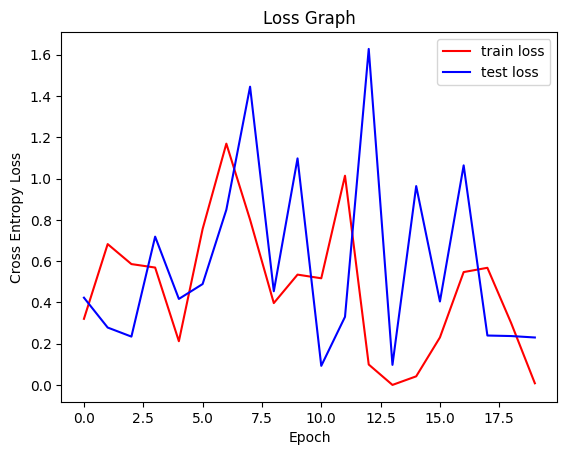

In [42]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

**Evaluasi Akurasi**

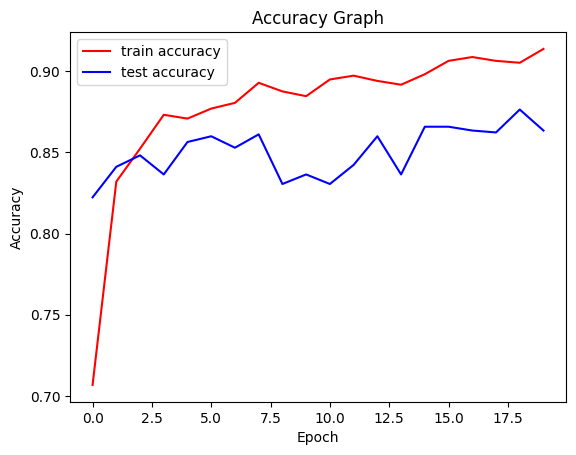

In [43]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [44]:
print(f"Akurasi Training Tertinggi: {max(train_accuracies):.2f}")
print(f"Akurasi Testing Tertinggi: {max(test_accuracies):.2f}")

Akurasi Training Tertinggi: 0.91
Akurasi Testing Tertinggi: 0.88


# Dengan Arsitektur VGG16

In [45]:
vgg16 = models.vgg16(pretrained=True)
vgg16

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.3MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [46]:
total_params = 0

for param in vgg16.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total parameters of the pretrained VGG16 model:", total_params)

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
102760448
4096
16777216
4096
4096000
1000
Total parameters of the pretrained VGG16 model: 138357544


In [47]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(1024,8),
    nn.LogSoftmax(dim=1)
)

vgg16 = vgg16.cuda()
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=vgg16.parameters(),lr=0.001)

In [49]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = vgg16(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = vgg16(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Durasi melatih model: {(time.time()-start_time)/60} menit.")

Epoch 1 Batch 50 -> Loss: 0.21981489658355713
Epoch 1 Batch 100 -> Loss: 0.4890245199203491
Epoch 2 Batch 50 -> Loss: 0.6909630298614502
Epoch 2 Batch 100 -> Loss: 0.25510838627815247
Epoch 3 Batch 50 -> Loss: 0.3315323293209076
Epoch 3 Batch 100 -> Loss: 0.45603305101394653
Epoch 4 Batch 50 -> Loss: 0.20755988359451294
Epoch 4 Batch 100 -> Loss: 0.06663455814123154
Epoch 5 Batch 50 -> Loss: 0.42552709579467773
Epoch 5 Batch 100 -> Loss: 0.40865710377693176
Epoch 6 Batch 50 -> Loss: 0.2106591761112213
Epoch 6 Batch 100 -> Loss: 0.08138923346996307
Epoch 7 Batch 50 -> Loss: 0.09961766749620438
Epoch 7 Batch 100 -> Loss: 0.4855191707611084
Epoch 8 Batch 50 -> Loss: 0.2356283813714981
Epoch 8 Batch 100 -> Loss: 0.06874828785657883
Epoch 9 Batch 50 -> Loss: 0.11362452059984207
Epoch 9 Batch 100 -> Loss: 0.2786739468574524
Epoch 10 Batch 50 -> Loss: 0.18702253699302673
Epoch 10 Batch 100 -> Loss: 0.33032017946243286
Epoch 11 Batch 50 -> Loss: 0.25192928314208984
Epoch 11 Batch 100 -> Loss: 

**Evaluasi Loss**

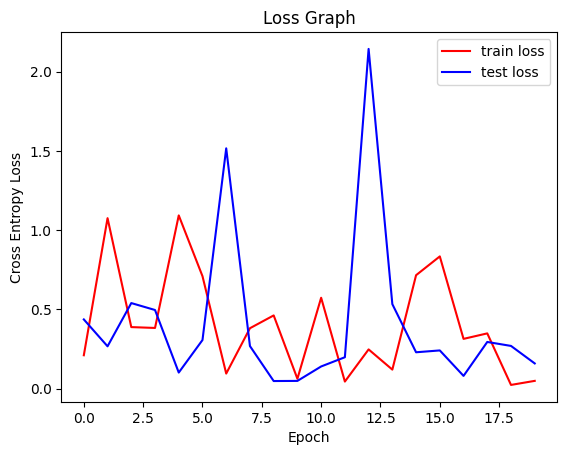

In [50]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

**Evaluasi Akurasi**

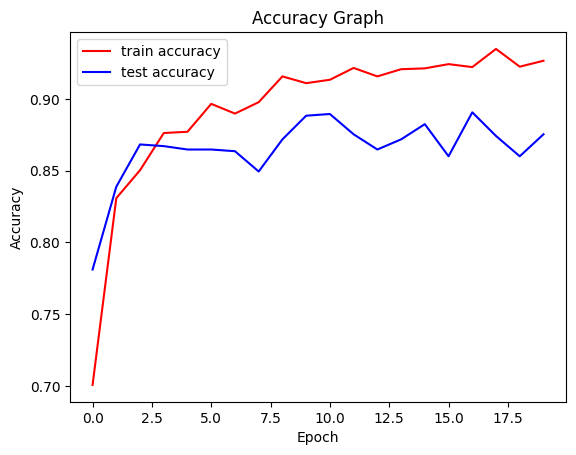

In [51]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [52]:
print(f"Akurasi Training Tertinggi: {max(train_accuracies):.2f}")
print(f"Akurasi Testing Tertinggi: {max(test_accuracies):.2f}")

Akurasi Training Tertinggi: 0.93
Akurasi Testing Tertinggi: 0.89


# Dengan Arsitektur MobileNet v3 Large

In [53]:
mobilenet = models.mobilenet_v3_large(pretrained=True)
mobilenet

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 143MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [54]:
total_params = 0

for param in mobilenet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total parameters of Mobile Net v3 Large model:", total_params)

432
16
16
144
16
16
256
16
16
1024
64
64
576
64
64
1536
24
24
1728
72
72
648
72
72
1728
24
24
1728
72
72
1800
72
72
1728
24
1728
72
2880
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
9600
240
240
2160
240
240
19200
80
80
16000
200
200
1800
200
200
16000
80
80
14720
184
184
1656
184
184
14720
80
80
14720
184
184
1656
184
184
14720
80
80
38400
480
480
4320
480
480
57600
120
57600
480
53760
112
112
75264
672
672
6048
672
672
112896
168
112896
672
75264
112
112
75264
672
672
16800
672
672
112896
168
112896
672
107520
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
1228800
1280
1280000
1000
Total parameters of Mobile Net v3 Large model: 5483032


In [55]:
mobilenet.classifier = nn.Sequential(
    nn.Linear(960,2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.4),
    nn.Linear(1024,8),
    nn.LogSoftmax(dim=1)
)

mobilenet = mobilenet.cuda()
mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=mobilenet.parameters(),lr=0.001)

In [57]:
start_time = time.time()

epochs = 20

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(1,epochs+1):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = mobilenet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 50 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = mobilenet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Durasi melatih model: {(time.time()-start_time)/60} menit.")

Epoch 1 Batch 50 -> Loss: 0.6290615797042847
Epoch 1 Batch 100 -> Loss: 0.5781285166740417
Epoch 2 Batch 50 -> Loss: 0.30336159467697144
Epoch 2 Batch 100 -> Loss: 0.3890818953514099
Epoch 3 Batch 50 -> Loss: 0.47493430972099304
Epoch 3 Batch 100 -> Loss: 0.43290966749191284
Epoch 4 Batch 50 -> Loss: 0.9241113066673279
Epoch 4 Batch 100 -> Loss: 0.7680032849311829
Epoch 5 Batch 50 -> Loss: 0.35453280806541443
Epoch 5 Batch 100 -> Loss: 0.35458043217658997
Epoch 6 Batch 50 -> Loss: 0.1847652941942215
Epoch 6 Batch 100 -> Loss: 0.481320858001709
Epoch 7 Batch 50 -> Loss: 0.24996531009674072
Epoch 7 Batch 100 -> Loss: 0.2797878384590149
Epoch 8 Batch 50 -> Loss: 0.16326908767223358
Epoch 8 Batch 100 -> Loss: 0.45832565426826477
Epoch 9 Batch 50 -> Loss: 0.36536356806755066
Epoch 9 Batch 100 -> Loss: 0.34599801898002625
Epoch 10 Batch 50 -> Loss: 0.09904199838638306
Epoch 10 Batch 100 -> Loss: 0.3449236750602722
Epoch 11 Batch 50 -> Loss: 0.13654012978076935
Epoch 11 Batch 100 -> Loss: 0.0

**Evaluasi Loss**

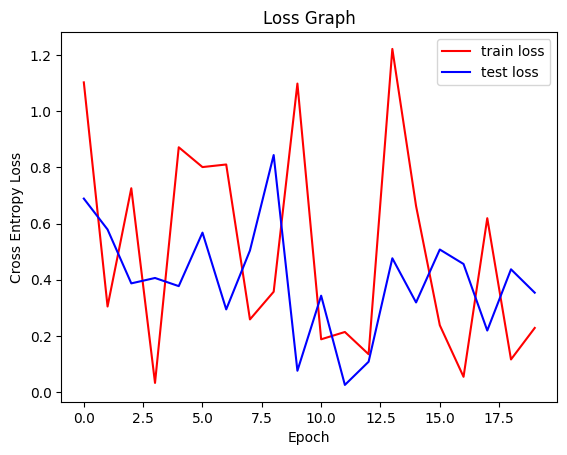

In [58]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

**Evaluasi Akurasi**

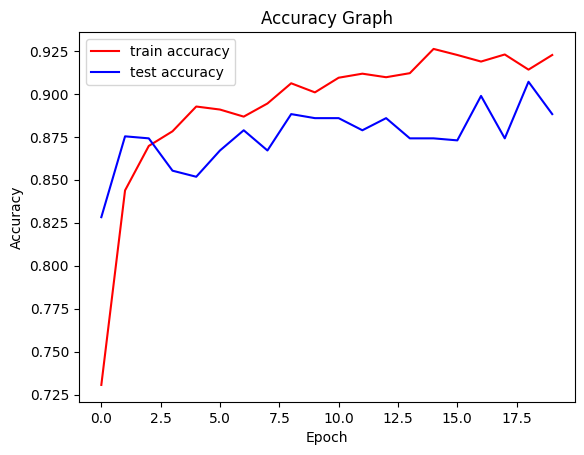

In [59]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [60]:
print(f"Akurasi Training Tertinggi: {max(train_accuracies):.2f}")
print(f"Akurasi Testing Tertinggi: {max(test_accuracies):.2f}")

Akurasi Training Tertinggi: 0.93
Akurasi Testing Tertinggi: 0.91


              precision    recall  f1-score   support

         dew       0.96      0.95      0.96       144
     fogsmog       0.87      0.89      0.88       169
   lightning       0.91      0.98      0.94        82
        rain       0.82      0.87      0.84       102
     rainbow       0.88      0.95      0.91        44
   sandstorm       0.93      0.91      0.92       148
        snow       0.94      0.76      0.84       121
       sunny       0.77      0.93      0.84        40

    accuracy                           0.90       850
   macro avg       0.88      0.90      0.89       850
weighted avg       0.90      0.90      0.90       850



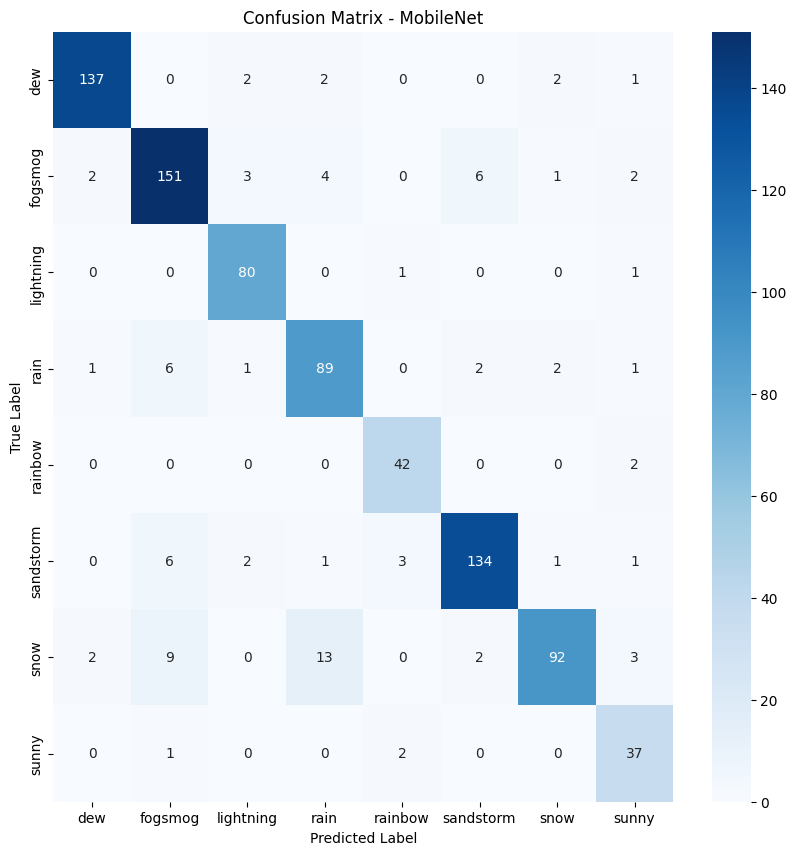

In [61]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = []
y_true = []

# iterasi melalui data testing
for inputs, labels in test_loader:
    inputs, labels = inputs.cuda(), labels.cuda()
    outputs = mobilenet(inputs) # gunakan model MobileNet (mobilenet)
    _, preds = torch.max(outputs, 1)

    y_pred.extend(preds.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

# classification report
print(classification_report(y_true, y_pred, target_names=dataset.classes))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# visualisasi confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - MobileNet') # judul spesifik untuk MobileNet
plt.show()

# Menyimpan Model

**Model CNN Based**

In [ ]:
torch.save(model,'weavis_cnn_based_model.pt')

In [ ]:
from google.colab import files
files.download('weavis_cnn_based_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model ResNet50**

In [ ]:
torch.save(resnet,'weavis_resnet50_model.pt')

In [ ]:
from google.colab import files
files.download('weavis_resnet50_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model AlexNet**

In [ ]:
torch.save(alexnet,'weavis_alexnet_model.pt')

In [ ]:
from google.colab import files
files.download('weavis_alexnet_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model VGG16**

In [ ]:
torch.save(vgg16,'weavis_vgg16_model.pt')

In [ ]:
from google.colab import files
files.download('weavis_vgg16_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model MobileNet v3 Large**

In [ ]:
torch.save(mobilenet,'weavis_mobilenetv3_large_model.pt')

In [ ]:
from google.colab import files
files.download('weavis_mobilenetv3_large_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>